In [21]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:
csv_url = r"C:\Users\GIA BAO\OneDrive - Trường ĐH CNTT - University of Information Technology\Vinamilk (1).csv"

In [24]:
data = pd.read_csv(csv_url, delimiter=';')

In [25]:
print(data)

            Date       Price        Open        High        Low      Vol  \
0     12/15/2023   68,100.00   68,500.00   68,600.00  68,100.00    3.74M   
1     12/14/2023   68,400.00   68,400.00   68,900.00  68,200.00    1.46M   
2     12/13/2023   68,200.00   69,600.00   69,700.00  68,100.00    4.51M   
3     12/12/2023   69,400.00   70,000.00   70,100.00  69,000.00    2.79M   
4     12/11/2023   70,000.00   70,500.00   70,500.00  69,900.00    4.73M   
...          ...         ...         ...         ...        ...      ...   
1724  01/20/2017  100,319.00   99,529.00  101,346.00  99,529.00    1.91M   
1725  01/19/2017   99,529.00   99,766.00   99,766.00  99,450.00    1.04M   
1726  01/18/2017   99,529.00   99,529.00   99,687.00  98,897.00    1.02M   
1727  01/17/2017   99,608.00  100,082.00  100,082.00  99,608.00  698.86K   
1728  01/16/2017   99,924.00  100,319.00  100,398.00  99,845.00  723.16K   

      Change  
0     -0.44%  
1      0.29%  
2     -1.73%  
3     -0.86%  
4      1.45%

In [26]:
# Convert the 'Date' column to datetime with the correct format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

In [27]:
data.sort_values(by='Date', inplace=True)
print(data)

                 Price        Open        High        Low      Vol  Change
Date                                                                      
2017-01-16   99,924.00  100,319.00  100,398.00  99,845.00  723.16K  -0.32%
2017-01-17   99,608.00  100,082.00  100,082.00  99,608.00  698.86K  -0.32%
2017-01-18   99,529.00   99,529.00   99,687.00  98,897.00    1.02M  -0.08%
2017-01-19   99,529.00   99,766.00   99,766.00  99,450.00    1.04M   0.00%
2017-01-20  100,319.00   99,529.00  101,346.00  99,529.00    1.91M   0.79%
...                ...         ...         ...        ...      ...     ...
2023-12-11   70,000.00   70,500.00   70,500.00  69,900.00    4.73M   1.45%
2023-12-12   69,400.00   70,000.00   70,100.00  69,000.00    2.79M  -0.86%
2023-12-13   68,200.00   69,600.00   69,700.00  68,100.00    4.51M  -1.73%
2023-12-14   68,400.00   68,400.00   68,900.00  68,200.00    1.46M   0.29%
2023-12-15   68,100.00   68,500.00   68,600.00  68,100.00    3.74M  -0.44%

[1729 rows x 6 columns]


In [28]:
# Remove ',' and convert format
cols_to_convert = ['Price', 'Open', 'High', 'Low']
data[cols_to_convert] = data[cols_to_convert].replace(',', '', regex=True).astype(float)

# Convert the format of the "Vol" column
def convert_vol(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'K' in value:
        return float(value.replace('K', '')) * 1e3
    else:
        return float(value)

data['Vol'] = data['Vol'].apply(convert_vol)

# Convert the format of the "Change" column
data['Change'] = data['Change'].replace('%', '', regex=True).astype(float) / 100.0


In [29]:
print(data)

               Price      Open      High      Low        Vol  Change
Date                                                                
2017-01-16   99924.0  100319.0  100398.0  99845.0   723160.0 -0.0032
2017-01-17   99608.0  100082.0  100082.0  99608.0   698860.0 -0.0032
2017-01-18   99529.0   99529.0   99687.0  98897.0  1020000.0 -0.0008
2017-01-19   99529.0   99766.0   99766.0  99450.0  1040000.0  0.0000
2017-01-20  100319.0   99529.0  101346.0  99529.0  1910000.0  0.0079
...              ...       ...       ...      ...        ...     ...
2023-12-11   70000.0   70500.0   70500.0  69900.0  4730000.0  0.0145
2023-12-12   69400.0   70000.0   70100.0  69000.0  2790000.0 -0.0086
2023-12-13   68200.0   69600.0   69700.0  68100.0  4510000.0 -0.0173
2023-12-14   68400.0   68400.0   68900.0  68200.0  1460000.0  0.0029
2023-12-15   68100.0   68500.0   68600.0  68100.0  3740000.0 -0.0044

[1729 rows x 6 columns]


In [30]:
# MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
# Split the data into Train-Val-Test sets with different ratios
# Ratio: 7:2:1
train_size_1 = int(0.7 * len(data))
test_size_1 = int(0.2 * len(data))
val_size_1 = len(data) - train_size_1 - test_size_1

train_1 = data[:train_size_1]
test_1 = data[train_size_1:train_size_1+test_size_1]
val_1 = data[train_size_1+test_size_1:]

#Ratio: 6:3:1
train_size_2 = int(0.6 * len(data))
test_size_2 = int(0.3 * len(data))
val_size_2 = len(data) - train_size_2 - test_size_2

train_2 = data[:train_size_2]
test_2 = data[train_size_2:train_size_2+test_size_2]
val_2 = data[train_size_2+test_size_2:]

#Ratio 5:3:2
train_size_3 = int(0.5 * len(data))
test_size_3 = int(0.3 * len(data))
val_size_3 = len(data) - train_size_3 - test_size_3

train_3 = data[:train_size_3]
test_3 = data[train_size_3:train_size_3+test_size_3]
val_3 = data[train_size_3+test_size_3:]

In [36]:
# Function to calculate RMSE, MAE, MAPE
def evaluate_model(train, test, val):
    exog_vars = ['Open', 'High', 'Low', 'Vol', 'Change']
    order = (1, 1, 1)

    # Build and train ARIMAX model on the training set
    model = SARIMAX(train['Price'], exog=train[exog_vars], order=order)
    results = model.fit(disp=False)

     # Predict on the validation and test set
    pred_test = results.get_forecast(steps=len(test), exog=test[exog_vars])
    pred_val = results.get_forecast(steps=len(val), exog=val[exog_vars])

     # Predict the next 30 days
    last_data = val.index[-1] + pd.DateOffset(1)
    next_30_days_index = pd.date_range(last_data, periods=30)
    pred_next_30_days = results.get_forecast(steps=30, exog=val[-30:][exog_vars])

    # Calculate evaluation metrics
    rmse_test = mean_squared_error(test['Price'], pred_test.predicted_mean, squared=False)
    mae_test = mean_absolute_error(test['Price'], pred_test.predicted_mean)
    mape_test = mean_absolute_percentage_error(test['Price'], pred_test.predicted_mean)

    rmse_val = mean_squared_error(val['Price'], pred_val.predicted_mean, squared=False)
    mae_val = mean_absolute_error(val['Price'], pred_val.predicted_mean)
    mape_val = mean_absolute_percentage_error(val['Price'], pred_val.predicted_mean)

    return (
        rmse_test, mae_test, mape_test,
        rmse_val, mae_val, mape_val,
        pred_test.predicted_mean, pred_val.predicted_mean, pred_next_30_days.predicted_mean
    )


In [37]:
# Evaluate the model with a ratio of 7:2:1
rmse_test_1, mae_test_1, mape_test_1, rmse_val_1, mae_val_1, mape_val_1, y_pred_test_1, y_pred_val_1, y_next_30_days_1 = evaluate_model(train_1, test_1, val_1)

# Evaluate the model with a ratio of 6:3:1
rmse_test_2, mae_test_2, mape_test_2, rmse_val_2, mae_val_2, mape_val_2, y_pred_test_2, y_pred_val_2, y_next_30_days_2 = evaluate_model(train_2, test_2, val_2)

# Evaluate the model with a ratio of 5:3:2
rmse_test_3, mae_test_3, mape_test_3, rmse_val_3, mae_val_3, mape_val_3, y_pred_test_3, y_pred_val_3, y_next_30_days_3 = evaluate_model(train_3, test_3, val_3)

C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available.

In [38]:
# Print result
print("Ratio 7:2:1")
print(f"RMSE Test: {rmse_test_1:.2f}, MAE Test: {mae_test_1:.2f}, MAPE Test: {mape_test_1:.2f}")
print(f"RMSE Validation: {rmse_val_1:.2f}, MAE Validation: {mae_val_1:.2f}, MAPE Validation: {mape_val_1:.2f}\n")

print("Ratio 6:3:1")
print(f"RMSE Test: {rmse_test_2:.2f}, MAE Test: {mae_test_2:.2f}, MAPE Test: {mape_test_2:.2f}")
print(f"RMSE Validation: {rmse_val_2:.2f}, MAE Validation: {mae_val_2:.2f}, MAPE Validation: {mape_val_2:.2f}\n")

print("Ratio 5:3:2")
print(f"RMSE Test: {rmse_test_3:.2f}, MAE Test: {mae_test_3:.2f}, MAPE Test: {mape_test_3:.2f}")
print(f"RMSE Validation: {rmse_val_3:.2f}, MAE Validation: {mae_val_3:.2f}, MAPE Validation: {mape_val_3:.2f}")

Ratio 7:2:1
RMSE Test: 799.55, MAE Test: 659.02, MAPE Test: 0.91
RMSE Validation: 884.83, MAE Validation: 787.45, MAPE Validation: 1.12

Ratio 6:3:1
RMSE Test: 772.91, MAE Test: 670.96, MAPE Test: 0.89
RMSE Validation: 886.55, MAE Validation: 810.26, MAPE Validation: 1.15

Ratio 5:3:2
RMSE Test: 824.88, MAE Test: 718.93, MAPE Test: 0.90
RMSE Validation: 966.59, MAE Validation: 887.83, MAPE Validation: 1.22


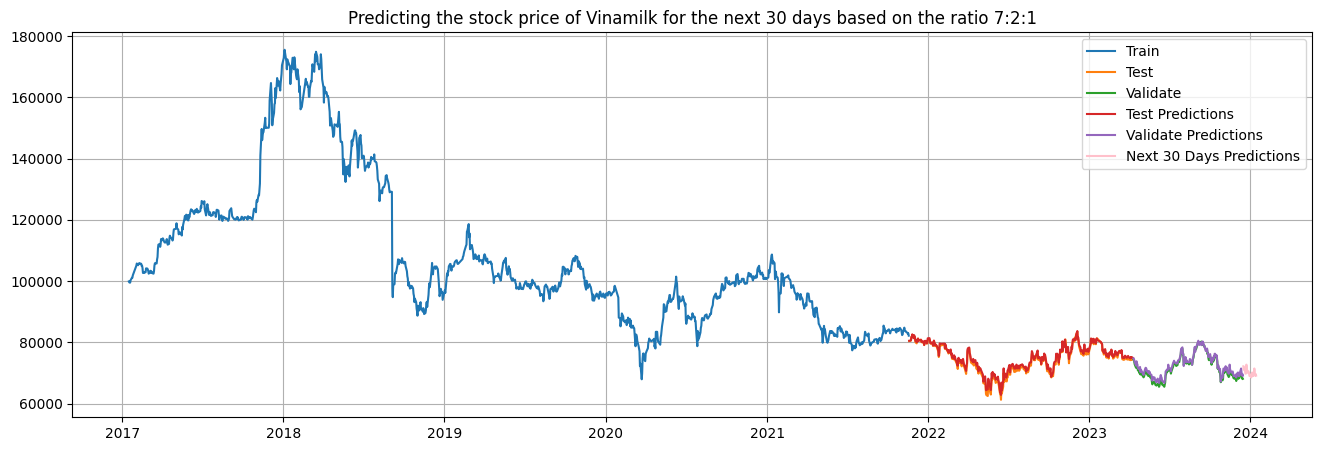

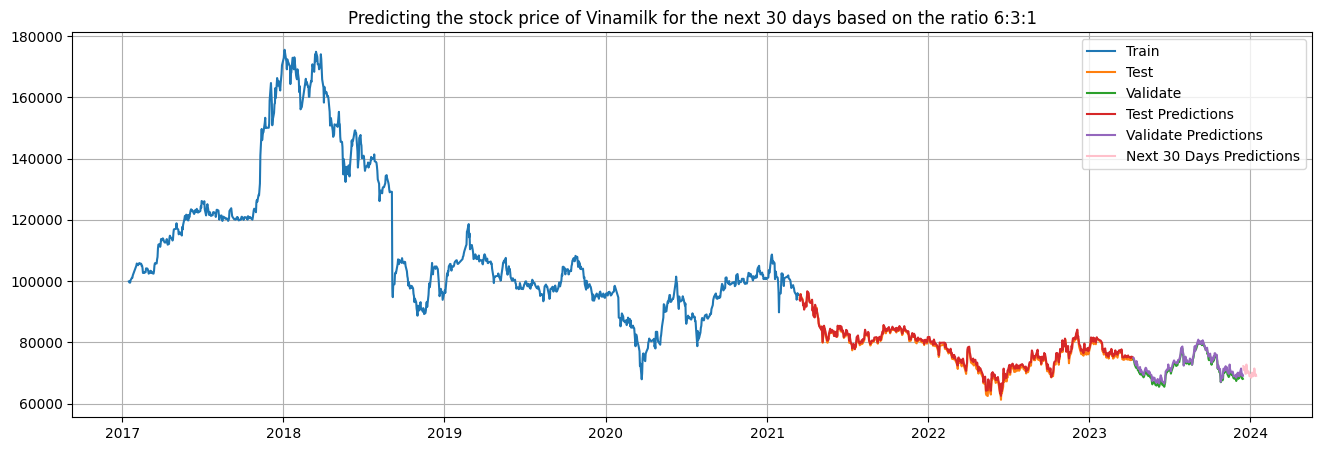

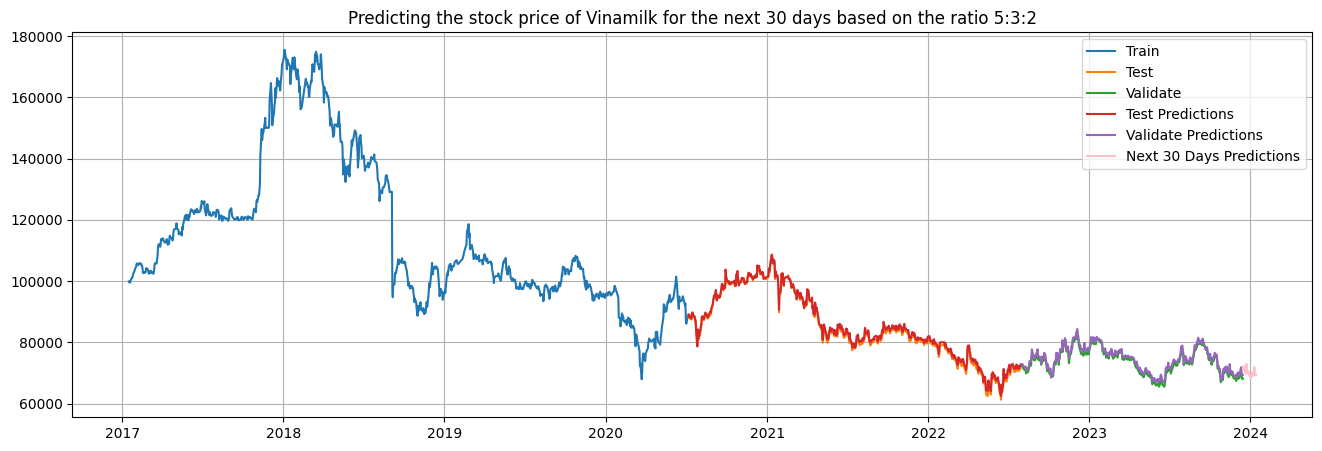

In [40]:
# Plotting function for multiple ratios
def plot_all_predictions(train, test, val, y_pred_test, y_pred_val, y_next_30_days, ratio_label):
    plt.figure(figsize=(16, 5))
    plt.title(f"Predicting the stock price of Vinamilk for the next 30 days based on the ratio {ratio_label}")
    plt.grid(True)
    
    # Plotting training, testing, and validation data
    plt.plot(train.index, train['Price'], label='Train')
    plt.plot(test.index, test['Price'], label='Test')
    plt.plot(val.index, val['Price'], label='Validate')

    # Plotting predictions for test and validation sets
    plt.plot(test.index[:len(y_pred_test)], y_pred_test, label='Test Predictions')
    plt.plot(val.index[:len(y_pred_val)], y_pred_val, label='Validate Predictions')

    # Plotting predictions for the next 30 days
    last_data = val.index[-1] + pd.DateOffset(1)  # Date for the first day of the next 30 days
    next_30_days_index = pd.date_range(last_data, periods=30)
    plt.plot(next_30_days_index, y_next_30_days, color="pink", label='Next 30 Days Predictions')

    plt.legend()
    plt.show()

# Plotting for all three ratios
plot_all_predictions(train_1, test_1, val_1, y_pred_test_1, y_pred_val_1, y_next_30_days_1, "7:2:1")
plot_all_predictions(train_2, test_2, val_2, y_pred_test_2, y_pred_val_2, y_next_30_days_2, "6:3:1")
plot_all_predictions(train_3, test_3, val_3, y_pred_test_3, y_pred_val_3, y_next_30_days_3, "5:3:2")